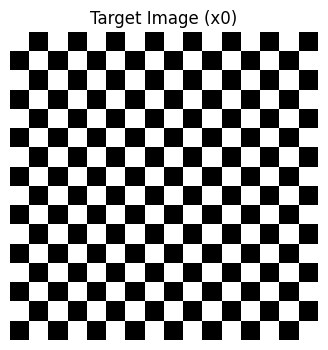

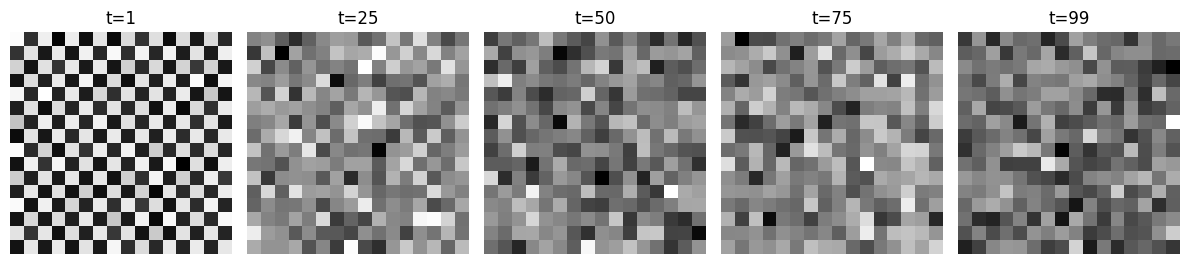

Model structure:
ImageDenoiseModel(
  (time_embed): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): SiLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Starting training...
Epoch 0, Loss: 0.916993
Epoch 300, Loss: 0.027434
Epoch 600, Loss: 0.217040
Epoch 900, Loss: 0.011543
Epoch 1200, Loss: 0.010928
Epoch 1500, Loss: 0.016894
Epoch 1800, Loss: 0.008864
Epoch 2100, Loss: 0.004427
Epoch 2400, Loss: 0.009210
Epoch 2700, Loss: 0.013643


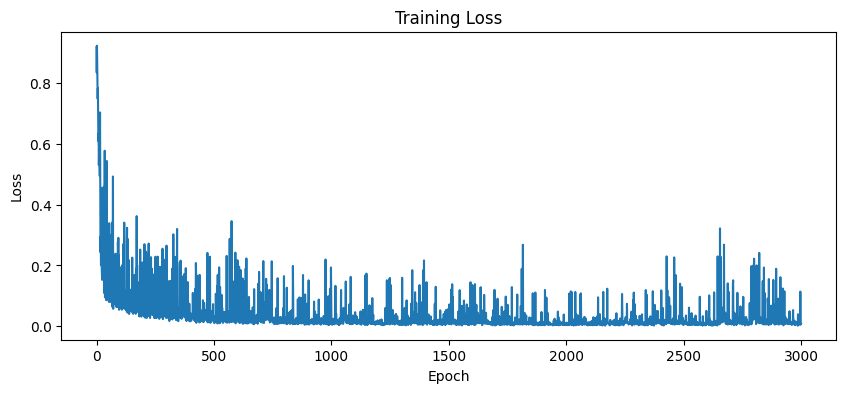

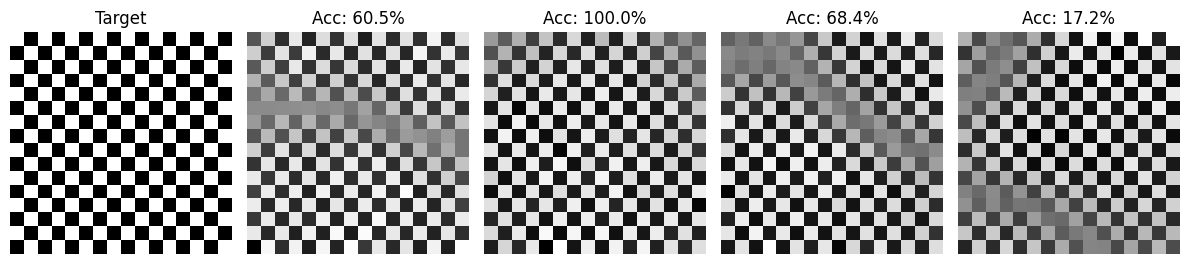

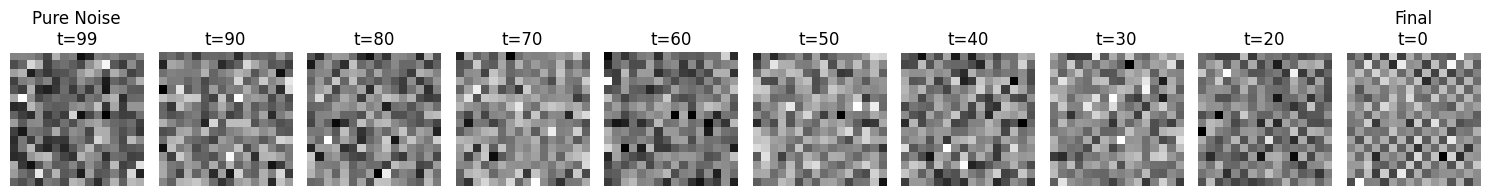

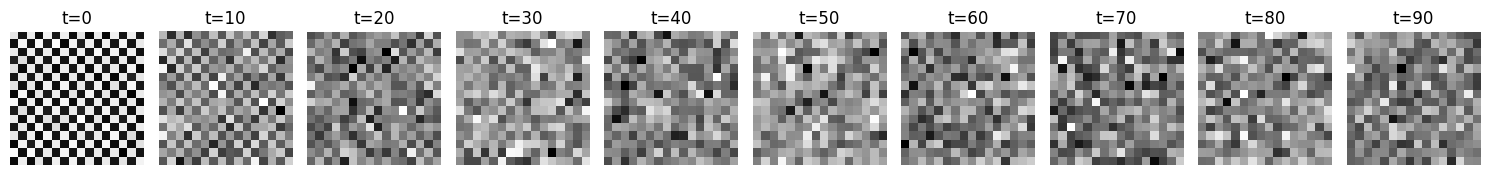


Final Accuracy Metrics:
Mean Squared Error: 0.329763
Pixel Accuracy: 59.79%
Structural Similarity: 0.200058


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.metrics import mean_squared_error
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
image_size = 16  # Small image size for simplicity
n_steps = 100
batch_size = 4
n_epochs = 3000
learning_rate = 1e-3

# Set up noise schedule (same as original)
alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Create a simple dataset - checkerboard pattern
def create_checkerboard(size=16):
    """Create a checkerboard pattern"""
    board = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i + j) % 2 == 0:
                board[i, j] = 1.0
    return board

# Create the target image
x0_image = create_checkerboard(image_size)
x0_tensor = torch.tensor(x0_image).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Visualize the target image
plt.figure(figsize=(4, 4))
plt.imshow(x0_image, cmap='gray')
plt.title("Target Image (x0)")
plt.axis('off')
plt.show()

# Forward process (adding noise) for images
def q_sample_image(x_0, t, noise=None):
    """Sample x at time t given x at t=0 and noise"""
    if noise is None:
        noise = torch.randn_like(x_0)

    t_expanded = t.expand(x_0.shape[0])
    return (
        sqrt_alphas_cumprod.gather(-1, t_expanded).view(-1, 1, 1, 1) * x_0 +
        sqrt_one_minus_alphas_cumprod.gather(-1, t_expanded).view(-1, 1, 1, 1) * noise
    )

# Visualize the forward process
plt.figure(figsize=(12, 3))
for i, t in enumerate([1, n_steps//4, n_steps//2, 3*n_steps//4, n_steps-1]):
    noise = torch.randn_like(x0_tensor)
    noisy_image = q_sample_image(x0_tensor, torch.tensor([t]), noise)

    plt.subplot(1, 5, i+1)
    plt.imshow(noisy_image[0, 0].numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Fixed denoising model for images
class ImageDenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN with time embedding
        self.time_embed = torch.nn.Sequential(
            torch.nn.Linear(1, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 16),
        )

        # Define channel sizes consistently
        self.in_channels = 1
        self.base_channels = 16

        # Downsampling path
        self.conv1 = torch.nn.Conv2d(self.in_channels, self.base_channels, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(self.base_channels + 16, self.base_channels * 2, 3, padding=1)

        # Upsampling path
        self.conv3 = torch.nn.Conv2d(self.base_channels * 2 + self.base_channels, self.base_channels, 3, padding=1)
        self.conv4 = torch.nn.Conv2d(self.base_channels + self.base_channels, self.in_channels, 3, padding=1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t.unsqueeze(-1).float() / n_steps)

        # Expand time embedding to spatial dimensions for concatenation
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.shape[2], x.shape[3])

        # Downsampling
        h1 = F.silu(self.conv1(x))  # [B, 16, H, W]
        # Concatenate time embedding with h1
        h1_with_time = torch.cat([h1, t_emb], dim=1)  # [B, 16+16, H, W]
        h2 = F.silu(self.conv2(h1_with_time))  # [B, 32, H, W]

        # Upsampling with skip connections
        h3 = F.silu(self.conv3(torch.cat([h2, h1], dim=1)))  # [B, 16, H, W]
        out = self.conv4(torch.cat([h3, h1], dim=1))  # [B, 1, H, W]

        return out

# Loss function
def p_loss_image(x, t):
    noise = torch.randn_like(x)
    noisy_x = q_sample_image(x, t, noise)
    noise_pred = denoise_model(noisy_x, t)
    return F.mse_loss(noise, noise_pred)

# Reverse process (denoising) for images
def p_sample_image(x, t):
    t_expanded = t.expand(x.shape[0])
    alpha_t = alphas.gather(-1, t_expanded).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t_expanded).view(-1, 1, 1, 1)

    # Predict noise
    noise_pred = denoise_model(x, t_expanded)

    # Calculate mean
    model_mean = torch.sqrt(1.0 / alpha_t) * (
        x - (1 - alpha_t) * noise_pred / sqrt_one_minus_alphas_cumprod_t
    )

    # Add variance
    model_var = posterior_variance.gather(-1, t_expanded).view(-1, 1, 1, 1)
    return model_mean + torch.sqrt(model_var) * torch.randn_like(x) if t[0] > 0 else model_mean

# Function to generate samples
def generate_samples(n_samples=4, save_intermediates=False):
    # Start with random noise
    x = torch.randn(n_samples, 1, image_size, image_size)

    intermediates = []
    if save_intermediates:
        intermediates.append(x.clone())

    # Denoise step by step
    for i in range(n_steps-1, -1, -1):
        t = torch.tensor([i])
        x = p_sample_image(x, t)
        if save_intermediates and i % 10 == 0:
            intermediates.append(x.clone())

    return x, intermediates

# Function to measure accuracy
def calculate_accuracy(generated, target):
    """Calculate accuracy metrics between generated and target images"""
    generated_np = generated.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()

    # MSE
    mse = mean_squared_error(
        target_np.reshape(-1),
        generated_np.reshape(-1)
    )

    # Binary accuracy (assuming threshold of 0.5)
    binary_gen = (generated_np > 0.5).astype(np.float32)
    binary_target = (target_np > 0.5).astype(np.float32)
    pixel_accuracy = np.mean(binary_gen == binary_target)

    # Structural similarity (simple version)
    mean_target = np.mean(target_np)
    mean_gen = np.mean(generated_np)
    std_target = np.std(target_np)
    std_gen = np.std(generated_np)
    cov = np.mean((generated_np - mean_gen) * (target_np - mean_target))

    ssim = (2 * mean_gen * mean_target) * (2 * cov)
    denom = (mean_gen**2 + mean_target**2) * (std_gen**2 + std_target**2)
    ssim = ssim / denom if denom != 0 else 0

    return {
        'mse': mse,
        'pixel_accuracy': pixel_accuracy * 100,  # Convert to percentage
        'ssim': ssim
    }

# Create visualization directory
os.makedirs('ddpm_results', exist_ok=True)

# Initialize and train the model
denoise_model = ImageDenoiseModel()
optimizer = torch.optim.Adam(denoise_model.parameters(), lr=learning_rate)

# Print model summary
print("Model structure:")
print(denoise_model)

# Training loop
losses = []
print("Starting training...")
for epoch in range(n_epochs):
    optimizer.zero_grad()
    t = torch.randint(0, n_steps, (batch_size,))
    loss = p_loss_image(x0_tensor.repeat(batch_size, 1, 1, 1), t)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        # Generate samples for visualization
        if epoch > 0:
            with torch.no_grad():
                samples, _ = generate_samples(4)

                # Plot samples
                plt.figure(figsize=(10, 3))
                plt.subplot(1, 5, 1)
                plt.imshow(x0_image, cmap='gray')
                plt.title("Target")
                plt.axis('off')

                for i in range(4):
                    plt.subplot(1, 5, i+2)
                    plt.imshow(samples[i, 0].numpy(), cmap='gray')
                    metrics = calculate_accuracy(samples[i], x0_tensor)
                    plt.title(f"Acc: {metrics['pixel_accuracy']:.1f}%")
                    plt.axis('off')

                plt.tight_layout()
                plt.savefig(f'ddpm_results/samples_epoch_{epoch}.png')
                plt.close()

# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('ddpm_results/loss_curve.png')
plt.show()

# Generate and visualize samples after training
with torch.no_grad():
    # Generate final samples
    samples, intermediates = generate_samples(4, save_intermediates=True)

    # Plot final samples with accuracy metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(x0_image, cmap='gray')
    plt.title("Target")
    plt.axis('off')

    for i in range(4):
        plt.subplot(1, 5, i+2)
        plt.imshow(samples[i, 0].numpy(), cmap='gray')
        metrics = calculate_accuracy(samples[i], x0_tensor)
        plt.title(f"Acc: {metrics['pixel_accuracy']:.1f}%")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('ddpm_results/final_samples.png')
    plt.show()

    # Plot reverse diffusion process (generation from noise to clean image)
    sample_idx = 0  # Choose which sample to visualize
    plt.figure(figsize=(15, 3))
    steps_to_show = min(10, len(intermediates))
    for i in range(steps_to_show):
        idx = i * (len(intermediates) // steps_to_show)
        plt.subplot(1, steps_to_show, i+1)
        plt.imshow(intermediates[idx][sample_idx, 0].numpy(), cmap='gray')
        if i == 0:
            plt.title("Pure Noise\nt=99")
        elif i == steps_to_show - 1:
            plt.title("Final\nt=0")
        else:
            step_t = n_steps - idx*10
            plt.title(f"t={step_t}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('ddpm_results/generation_process.png')
    plt.show()

# Also visualize the forward process (adding noise) in more detail
plt.figure(figsize=(15, 3))
steps_to_show = 10
for i in range(steps_to_show):
    t = i * (n_steps // steps_to_show)
    noise = torch.randn_like(x0_tensor)
    noisy_image = q_sample_image(x0_tensor, torch.tensor([t]), noise)

    plt.subplot(1, steps_to_show, i+1)
    plt.imshow(noisy_image[0, 0].numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('ddpm_results/forward_process.png')
plt.show()

# Calculate and print final accuracy metrics
with torch.no_grad():
    # Generate multiple samples for robust evaluation
    n_eval_samples = 16
    all_samples, _ = generate_samples(n_eval_samples)

    # Calculate metrics for each sample
    all_metrics = []
    for i in range(n_eval_samples):
        metrics = calculate_accuracy(all_samples[i], x0_tensor)
        all_metrics.append(metrics)

    # Average metrics
    avg_metrics = {
        'mse': np.mean([m['mse'] for m in all_metrics]),
        'pixel_accuracy': np.mean([m['pixel_accuracy'] for m in all_metrics]),
        'ssim': np.mean([m['ssim'] for m in all_metrics])
    }

    print("\nFinal Accuracy Metrics:")
    print(f"Mean Squared Error: {avg_metrics['mse']:.6f}")
    print(f"Pixel Accuracy: {avg_metrics['pixel_accuracy']:.2f}%")
    print(f"Structural Similarity: {avg_metrics['ssim']:.6f}")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.metrics import mean_squared_error
import os
import copy

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
image_size = 16  # Small image size for simplicity
n_steps = 100
batch_size = 4
n_epochs = 3000
learning_rate = 1e-3

# Pruning percentages to evaluate
pruning_percentages = [0.1, 0.25, 0.5, 0.75, 0.9]  # 10%, 25%, 50%, 75%, 90%

# Set up noise schedule (same as original)
alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Create a simple dataset - checkerboard pattern
def create_checkerboard(size=16):
    """Create a checkerboard pattern"""
    board = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i + j) % 2 == 0:
                board[i, j] = 1.0
    return board

# Create the target image
x0_image = create_checkerboard(image_size)
x0_tensor = torch.tensor(x0_image).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Forward process (adding noise) for images
def q_sample_image(x_0, t, noise=None):
    """Sample x at time t given x at t=0 and noise"""
    if noise is None:
        noise = torch.randn_like(x_0)

    t_expanded = t.expand(x_0.shape[0])
    return (
        sqrt_alphas_cumprod.gather(-1, t_expanded).view(-1, 1, 1, 1) * x_0 +
        sqrt_one_minus_alphas_cumprod.gather(-1, t_expanded).view(-1, 1, 1, 1) * noise
    )

# Fixed denoising model for images
class ImageDenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN with time embedding
        self.time_embed = torch.nn.Sequential(
            torch.nn.Linear(1, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 16),
        )

        # Define channel sizes consistently
        self.in_channels = 1
        self.base_channels = 16

        # Downsampling path
        self.conv1 = torch.nn.Conv2d(self.in_channels, self.base_channels, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(self.base_channels + 16, self.base_channels * 2, 3, padding=1)

        # Upsampling path
        self.conv3 = torch.nn.Conv2d(self.base_channels * 2 + self.base_channels, self.base_channels, 3, padding=1)
        self.conv4 = torch.nn.Conv2d(self.base_channels + self.base_channels, self.in_channels, 3, padding=1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t.unsqueeze(-1).float() / n_steps)

        # Expand time embedding to spatial dimensions for concatenation
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.shape[2], x.shape[3])

        # Downsampling
        h1 = F.silu(self.conv1(x))  # [B, 16, H, W]
        # Concatenate time embedding with h1
        h1_with_time = torch.cat([h1, t_emb], dim=1)  # [B, 16+16, H, W]
        h2 = F.silu(self.conv2(h1_with_time))  # [B, 32, H, W]

        # Upsampling with skip connections
        h3 = F.silu(self.conv3(torch.cat([h2, h1], dim=1)))  # [B, 16, H, W]
        out = self.conv4(torch.cat([h3, h1], dim=1))  # [B, 1, H, W]

        return out

# Loss function
def p_loss_image(model, x, t):
    noise = torch.randn_like(x)
    noisy_x = q_sample_image(x, t, noise)
    noise_pred = model(noisy_x, t)
    return F.mse_loss(noise, noise_pred)

# Reverse process (denoising) for images
def p_sample_image(model, x, t):
    t_expanded = t.expand(x.shape[0])
    alpha_t = alphas.gather(-1, t_expanded).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t_expanded).view(-1, 1, 1, 1)

    # Predict noise
    noise_pred = model(x, t_expanded)

    # Calculate mean
    model_mean = torch.sqrt(1.0 / alpha_t) * (
        x - (1 - alpha_t) * noise_pred / sqrt_one_minus_alphas_cumprod_t
    )

    # Add variance
    model_var = posterior_variance.gather(-1, t_expanded).view(-1, 1, 1, 1)
    return model_mean + torch.sqrt(model_var) * torch.randn_like(x) if t[0] > 0 else model_mean

# Function to generate samples
def generate_samples(model, n_samples=4, save_intermediates=False):
    # Start with random noise
    x = torch.randn(n_samples, 1, image_size, image_size)

    intermediates = []
    if save_intermediates:
        intermediates.append(x.clone())

    # Denoise step by step
    for i in range(n_steps-1, -1, -1):
        t = torch.tensor([i])
        x = p_sample_image(model, x, t)
        if save_intermediates and i % 10 == 0:
            intermediates.append(x.clone())

    return x, intermediates

# Function to measure accuracy
def calculate_accuracy(generated, target):
    """Calculate accuracy metrics between generated and target images"""
    generated_np = generated.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()

    # MSE
    mse = mean_squared_error(
        target_np.reshape(-1),
        generated_np.reshape(-1)
    )

    # Binary accuracy (assuming threshold of 0.5)
    binary_gen = (generated_np > 0.5).astype(np.float32)
    binary_target = (target_np > 0.5).astype(np.float32)
    pixel_accuracy = np.mean(binary_gen == binary_target)

    # Structural similarity (simple version)
    mean_target = np.mean(target_np)
    mean_gen = np.mean(generated_np)
    std_target = np.std(target_np)
    std_gen = np.std(generated_np)
    cov = np.mean((generated_np - mean_gen) * (target_np - mean_target))

    ssim = (2 * mean_gen * mean_target) * (2 * cov)
    denom = (mean_gen**2 + mean_target**2) * (std_gen**2 + std_target**2)
    ssim = ssim / denom if denom != 0 else 0

    return {
        'mse': mse,
        'pixel_accuracy': pixel_accuracy * 100,  # Convert to percentage
        'ssim': ssim
    }

# Function to evaluate model performance
def evaluate_model(model, n_eval_samples=16):
    with torch.no_grad():
        # Generate multiple samples for robust evaluation
        all_samples, _ = generate_samples(model, n_eval_samples)

        # Calculate metrics for each sample
        all_metrics = []
        for i in range(n_eval_samples):
            metrics = calculate_accuracy(all_samples[i], x0_tensor)
            all_metrics.append(metrics)

        # Average metrics
        avg_metrics = {
            'mse': np.mean([m['mse'] for m in all_metrics]),
            'pixel_accuracy': np.mean([m['pixel_accuracy'] for m in all_metrics]),
            'ssim': np.mean([m['ssim'] for m in all_metrics])
        }

        return avg_metrics

# Create visualization directory
os.makedirs('ddpm_pruning_results', exist_ok=True)

# Train the base model
def train_model(model, epochs=n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        t = torch.randint(0, n_steps, (batch_size,))
        loss = p_loss_image(model, x0_tensor.repeat(batch_size, 1, 1, 1), t)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % (epochs // 10) == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return losses

# IMP Pruning Implementation
def apply_imp_pruning(model, prune_percent):
    """Apply Iterative Magnitude Pruning"""
    # Create a mask dictionary for each weight tensor
    masks = {}

    # Get all weight parameters
    for name, param in model.named_parameters():
        if 'weight' in name:  # Only apply to weight parameters, not biases
            # Create a mask tensor of the same shape
            masks[name] = torch.ones_like(param)

    # Calculate total parameters in weights
    total_params = sum(param.numel() for name, param in model.named_parameters() if 'weight' in name)

    # Calculate number of parameters to prune
    num_to_prune = int(total_params * prune_percent)

    if num_to_prune <= 0:
        return model, masks

    # Get all weights in a flat tensor
    all_weights = torch.cat([param.data.view(-1) for name, param in model.named_parameters() if 'weight' in name])

    # Find magnitude threshold for pruning
    sorted_weights = torch.sort(torch.abs(all_weights))[0]
    threshold = sorted_weights[num_to_prune]

    # Apply pruning to each weight tensor
    params_pruned = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Update mask: 0 for weights below threshold, 1 for others
            mask = (torch.abs(param.data) > threshold).float()
            masks[name] = mask

            # Apply mask to weights (zero out pruned weights)
            param.data = param.data * mask

            # Count pruned parameters
            params_pruned += (mask == 0).sum().item()

    print(f"IMP Pruning: {params_pruned}/{total_params} parameters pruned ({params_pruned/total_params:.2%})")

    # Generate and save sample images after pruning
    with torch.no_grad():
        samples, _ = generate_samples(model, 4)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 5, 1)
        plt.imshow(x0_image, cmap='gray')
        plt.title("Target")
        plt.axis('off')

        for i in range(4):
            plt.subplot(1, 5, i+2)
            plt.imshow(samples[i, 0].numpy(), cmap='gray')
            metrics = calculate_accuracy(samples[i], x0_tensor)
            plt.title(f"Acc: {metrics['pixel_accuracy']:.1f}%")
            plt.axis('off')

        plt.suptitle(f"IMP {prune_percent*100:.0f}% Pruned")
        plt.tight_layout()
        plt.savefig(f'ddpm_pruning_results/imp_pruned_{int(prune_percent*100)}.png')
        plt.close()

    return model, masks

# HSP Pruning Implementation
def apply_hsp_pruning(model, prune_percent):
    """Apply Hilbert-Schmidt Pruning"""
    # Get all weight parameters and compute their importance scores
    importance_scores = {}
    layer_sizes = {}

    for name, param in model.named_parameters():
        if 'weight' in name:  # Only apply to weight parameters
            # For linear layers, compute Hilbert-Schmidt norm
            if len(param.shape) == 2:  # Linear layer
                # HSP importance is the squared Frobenius norm of weights
                importance = torch.sum(param.data ** 2)
                # For per-neuron importance (for output neurons)
                neuron_importance = torch.sum(param.data ** 2, dim=1)

            # For convolutional layers
            elif len(param.shape) == 4:  # Conv2d layer
                # For Conv2d, importance per output channel
                neuron_importance = torch.sum(param.data ** 2, dim=(1, 2, 3))
                importance = torch.sum(neuron_importance)

            else:
                # For other layer types, use magnitude as fallback
                neuron_importance = torch.sum(torch.abs(param.data), dim=list(range(1, len(param.shape))))
                importance = torch.sum(torch.abs(param.data))

            importance_scores[name] = neuron_importance
            layer_sizes[name] = param.shape[0]  # Number of output neurons

    # Calculate total neurons across all layers
    total_neurons = sum(layer_sizes.values())

    # Number of neurons to prune
    num_neurons_to_prune = int(total_neurons * prune_percent)

    # Flatten all importance scores
    all_scores = []
    for name, scores in importance_scores.items():
        for idx, score in enumerate(scores):
            all_scores.append((name, idx, score.item()))

    # Sort neurons by importance (ascending)
    all_scores.sort(key=lambda x: x[2])

    # Get neurons to prune
    neurons_to_prune = all_scores[:num_neurons_to_prune]

    # Create pruning masks
    masks = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            masks[name] = torch.ones_like(param)

    # Apply neuron pruning
    for name, idx, _ in neurons_to_prune:
        if len(model.state_dict()[name].shape) == 2:  # Linear layer
            masks[name][idx, :] = 0  # Zero out entire row
        elif len(model.state_dict()[name].shape) == 4:  # Conv2d layer
            masks[name][idx, :, :, :] = 0  # Zero out entire output channel

    # Apply masks to weights
    params_pruned = 0
    total_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            param.data = param.data * masks[name]
            params_pruned += (masks[name] == 0).sum().item()

    print(f"HSP Pruning: {params_pruned}/{total_params} parameters pruned ({params_pruned/total_params:.2%})")

    # Generate and save sample images after pruning
    with torch.no_grad():
        samples, _ = generate_samples(model, 4)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 5, 1)
        plt.imshow(x0_image, cmap='gray')
        plt.title("Target")
        plt.axis('off')

        for i in range(4):
            plt.subplot(1, 5, i+2)
            plt.imshow(samples[i, 0].numpy(), cmap='gray')
            metrics = calculate_accuracy(samples[i], x0_tensor)
            plt.title(f"Acc: {metrics['pixel_accuracy']:.1f}%")
            plt.axis('off')

        plt.suptitle(f"HSP {prune_percent*100:.0f}% Pruned")
        plt.tight_layout()
        plt.savefig(f'ddpm_pruning_results/hsp_pruned_{int(prune_percent*100)}.png')
        plt.close()

    return model, masks

# Function to count non-zero parameters
def count_nonzero_params(model):
    """Count non-zero parameters in the model"""
    total = 0
    nonzero = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total += param.numel()
            nonzero += (param.data != 0).sum().item()
    return nonzero, total, nonzero/total

# Main experiment function
def run_pruning_experiments():
    # Train the base model
    print("Training base model...")
    base_model = ImageDenoiseModel()
    train_model(base_model)

    # Evaluate base model
    base_metrics = evaluate_model(base_model)
    print("\nBase Model Metrics:")
    print(f"Mean Squared Error: {base_metrics['mse']:.6f}")
    print(f"Pixel Accuracy: {base_metrics['pixel_accuracy']:.2f}%")
    print(f"Structural Similarity: {base_metrics['ssim']:.6f}")

    # Save base model metrics
    results = {
        'base': {
            'metrics': base_metrics,
            'params': count_nonzero_params(base_model)
        },
        'imp': {},
        'hsp': {}
    }

    # Run IMP pruning experiments
    print("\n--- Running IMP Pruning Experiments ---")
    for percent in pruning_percentages:
        print(f"\nPruning {percent*100:.0f}% of parameters with IMP...")

        # Create a copy of the base model
        imp_model = copy.deepcopy(base_model)

        # Apply IMP pruning
        imp_model, _ = apply_imp_pruning(imp_model, percent)

        # Evaluate
        imp_metrics = evaluate_model(imp_model)
        param_stats = count_nonzero_params(imp_model)

        print(f"IMP {percent*100:.0f}% Pruning Metrics:")
        print(f"Non-zero parameters: {param_stats[0]}/{param_stats[1]} ({param_stats[2]:.2%})")
        print(f"Mean Squared Error: {imp_metrics['mse']:.6f}")
        print(f"Pixel Accuracy: {imp_metrics['pixel_accuracy']:.2f}%")
        print(f"Structural Similarity: {imp_metrics['ssim']:.6f}")

        # Save results
        results['imp'][percent] = {
            'metrics': imp_metrics,
            'params': param_stats
        }

        # Generate and save sample images
        with torch.no_grad():
            samples, _ = generate_samples(imp_model, 4)

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 5, 1)
            plt.imshow(x0_image, cmap='gray')
            plt.title("Target")
            plt.axis('off')

            for i in range(4):
                plt.subplot(1, 5, i+2)
                plt.imshow(samples[i, 0].numpy(), cmap='gray')
                metrics = calculate_accuracy(samples[i], x0_tensor)
                plt.title(f"Acc: {metrics['pixel_accuracy']:.1f}%")
                plt.axis('off')

            plt.suptitle(f"IMP {percent*100:.0f}% Pruned")
            plt.tight_layout()
            plt.savefig(f'ddpm_pruning_results/imp_pruned_{int(percent*100)}.png')
            plt.close()

    # Run HSP pruning experiments
    print("\n--- Running HSP Pruning Experiments ---")
    for percent in pruning_percentages:
        print(f"\nPruning {percent*100:.0f}% of parameters with HSP...")

        # Create a copy of the base model
        hsp_model = copy.deepcopy(base_model)

        # Apply HSP pruning
        hsp_model, _ = apply_hsp_pruning(hsp_model, percent)

        # Evaluate
        hsp_metrics = evaluate_model(hsp_model)
        param_stats = count_nonzero_params(hsp_model)

        print(f"HSP {percent*100:.0f}% Pruning Metrics:")
        print(f"Non-zero parameters: {param_stats[0]}/{param_stats[1]} ({param_stats[2]:.2%})")
        print(f"Mean Squared Error: {hsp_metrics['mse']:.6f}")
        print(f"Pixel Accuracy: {hsp_metrics['pixel_accuracy']:.2f}%")
        print(f"Structural Similarity: {hsp_metrics['ssim']:.6f}")

        # Save results
        results['hsp'][percent] = {
            'metrics': hsp_metrics,
            'params': param_stats
        }

        # Generate and save sample images
        with torch.no_grad():
            samples, _ = generate_samples(hsp_model, 4)

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 5, 1)
            plt.imshow(x0_image, cmap='gray')
            plt.title("Target")
            plt.axis('off')

            for i in range(4):
                plt.subplot(1, 5, i+2)
                plt.imshow(samples[i, 0].numpy(), cmap='gray')
                metrics = calculate_accuracy(samples[i], x0_tensor)
                plt.title(f"Acc: {metrics['pixel_accuracy']:.1f}%")
                plt.axis('off')

            plt.suptitle(f"HSP {percent*100:.0f}% Pruned")
            plt.tight_layout()
            plt.savefig(f'ddpm_pruning_results/hsp_pruned_{int(percent*100)}.png')
            plt.close()

    # Generate comparison plots
    plot_comparative_results(results)

    return results

def plot_comparative_results(results):
    """Generate comparative plots for IMP vs HSP vs Base model"""
    # Prepare data for plotting
    percentages = sorted(list(results['imp'].keys()))

    # Accuracy comparison
    plt.figure(figsize=(10, 6))

    # Plot base model accuracy as horizontal line
    plt.axhline(y=results['base']['metrics']['pixel_accuracy'], color='k', linestyle='-', label='Base Model')

    # Plot IMP and HSP accuracies
    imp_acc = [results['imp'][p]['metrics']['pixel_accuracy'] for p in percentages]
    hsp_acc = [results['hsp'][p]['metrics']['pixel_accuracy'] for p in percentages]

    plt.plot(np.array(percentages)*100, imp_acc, 'o-', label='IMP Pruning')
    plt.plot(np.array(percentages)*100, hsp_acc, 's-', label='HSP Pruning')

    plt.xlabel('Pruning Percentage (%)')
    plt.ylabel('Pixel Accuracy (%)')
    plt.title('Accuracy vs Pruning Percentage')
    plt.legend()
    plt.grid(True)
    plt.savefig('ddpm_pruning_results/accuracy_comparison.png')
    plt.close()

    # MSE comparison
    plt.figure(figsize=(10, 6))
    plt.axhline(y=results['base']['metrics']['mse'], color='k', linestyle='-', label='Base Model')

    imp_mse = [results['imp'][p]['metrics']['mse'] for p in percentages]
    hsp_mse = [results['hsp'][p]['metrics']['mse'] for p in percentages]

    plt.plot(np.array(percentages)*100, imp_mse, 'o-', label='IMP Pruning')
    plt.plot(np.array(percentages)*100, hsp_mse, 's-', label='HSP Pruning')

    plt.xlabel('Pruning Percentage (%)')
    plt.ylabel('Mean Squared Error')
    plt.title('Error vs Pruning Percentage')
    plt.legend()
    plt.grid(True)
    plt.savefig('ddpm_pruning_results/mse_comparison.png')
    plt.close()

    # SSIM comparison
    plt.figure(figsize=(10, 6))
    plt.axhline(y=results['base']['metrics']['ssim'], color='k', linestyle='-', label='Base Model')

    imp_ssim = [results['imp'][p]['metrics']['ssim'] for p in percentages]
    hsp_ssim = [results['hsp'][p]['metrics']['ssim'] for p in percentages]

    plt.plot(np.array(percentages)*100, imp_ssim, 'o-', label='IMP Pruning')
    plt.plot(np.array(percentages)*100, hsp_ssim, 's-', label='HSP Pruning')

    plt.xlabel('Pruning Percentage (%)')
    plt.ylabel('Structural Similarity (SSIM)')
    plt.title('SSIM vs Pruning Percentage')
    plt.legend()
    plt.grid(True)
    plt.savefig('ddpm_pruning_results/ssim_comparison.png')
    plt.close()

    # Create summary table
    plt.figure(figsize=(12, 8))
    plt.axis('off')

    table_data = [
        ['Method', 'Prune %', 'Params Remain', 'Accuracy (%)', 'MSE', 'SSIM']
    ]

    # Add base model
    base_params = results['base']['params']
    table_data.append(['Base', '0%', f'{base_params[0]}/{base_params[1]} ({base_params[2]:.2%})',
                      f"{results['base']['metrics']['pixel_accuracy']:.2f}",
                      f"{results['base']['metrics']['mse']:.6f}",
                      f"{results['base']['metrics']['ssim']:.6f}"])

    # Add IMP results
    for p in percentages:
        imp_params = results['imp'][p]['params']
        table_data.append([f'IMP', f'{p*100:.0f}%',
                          f'{imp_params[0]}/{imp_params[1]} ({imp_params[2]:.2%})',
                          f"{results['imp'][p]['metrics']['pixel_accuracy']:.2f}",
                          f"{results['imp'][p]['metrics']['mse']:.6f}",
                          f"{results['imp'][p]['metrics']['ssim']:.6f}"])

    # Add HSP results
    for p in percentages:
        hsp_params = results['hsp'][p]['params']
        table_data.append([f'HSP', f'{p*100:.0f}%',
                          f'{hsp_params[0]}/{hsp_params[1]} ({hsp_params[2]:.2%})',
                          f"{results['hsp'][p]['metrics']['pixel_accuracy']:.2f}",
                          f"{results['hsp'][p]['metrics']['mse']:.6f}",
                          f"{results['hsp'][p]['metrics']['ssim']:.6f}"])

    plt.table(cellText=table_data[1:], colLabels=table_data[0], loc='center', cellLoc='center')
    plt.title('Pruning Methods Comparison', y=0.9)
    plt.tight_layout()
    plt.savefig('ddpm_pruning_results/comparison_table.png')
    plt.close()

# Run the experiments
if __name__ == "__main__":
    results = run_pruning_experiments()

    # Print final summary
    print("\n===== FINAL COMPARISON =====")
    print("Base Model:")
    base_params = results['base']['params']
    print(f"  Parameters: {base_params[0]}/{base_params[1]} ({base_params[2]:.2%})")
    print(f"  Accuracy: {results['base']['metrics']['pixel_accuracy']:.2f}%")
    print(f"  MSE: {results['base']['metrics']['mse']:.6f}")
    print(f"  SSIM: {results['base']['metrics']['ssim']:.6f}")

    for method in ['imp', 'hsp']:
        print(f"\n{method.upper()} Pruning Results:")
        for percent in pruning_percentages:
            params = results[method][percent]['params']
            print(f"  {percent*100:.0f}% Pruned:")
            print(f"    Parameters: {params[0]}/{params[1]} ({params[2]:.2%})")
            print(f"    Accuracy: {results[method][percent]['metrics']['pixel_accuracy']:.2f}%")
            print(f"    MSE: {results[method][percent]['metrics']['mse']:.6f}")
            print(f"    SSIM: {results[method][percent]['metrics']['ssim']:.6f}")

Training base model...
Epoch 0, Loss: 1.023678
Epoch 300, Loss: 0.043408
Epoch 600, Loss: 0.008790
Epoch 900, Loss: 0.024026
Epoch 1200, Loss: 0.019208
Epoch 1500, Loss: 0.018547
Epoch 1800, Loss: 0.009317
Epoch 2100, Loss: 0.004264
Epoch 2400, Loss: 0.009478
Epoch 2700, Loss: 0.014400

Base Model Metrics:
Mean Squared Error: 0.390248
Pixel Accuracy: 53.34%
Structural Similarity: 0.073538

--- Running IMP Pruning Experiments ---

Pruning 10% of parameters with IMP...
IMP Pruning: 1684/16832 parameters pruned (10.00%)
IMP 10% Pruning Metrics:
Non-zero parameters: 15148/16832 (90.00%)
Mean Squared Error: 0.407822
Pixel Accuracy: 51.51%
Structural Similarity: 0.032071

Pruning 25% of parameters with IMP...
IMP Pruning: 4209/16832 parameters pruned (25.01%)
IMP 25% Pruning Metrics:
Non-zero parameters: 12623/16832 (74.99%)
Mean Squared Error: 0.267281
Pixel Accuracy: 67.43%
Structural Similarity: 0.346383

Pruning 50% of parameters with IMP...
IMP Pruning: 8417/16832 parameters pruned (50.